### Regresión Logística - Pair programming ###

## 1. EDA ##

In [3]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd


# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns


#  Gestión de warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

Para los ejercicios de pair programming de Regresión logística tendremos que buscar un dataset (al igual que hicismos en regresión lineal) que usaremos a lo largo de los siguientes ejercicios.

Se ruega a la hora de realizar la entrega que incluyais el conjunto de datos que hayais decidido emplear para estos ejercicios.

Objetivos

Buscar un conjunto de datos a analizar

Se recomienda que el conjunto de datos a analizar tenga variables numéricas y categóricas, primando que haya más de una variable de tipo numérico.

Explicar los datos y las variables disponibles en el conjunto de datos seleccionado

Realizar un EDA sencillo poniendo en práctica los conocimientos adquiridos hasta el momento.

Interpretación de los resultados.

In [5]:
df = pd.read_csv("data/card_transdata.csv")
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [7]:
df.duplicated().sum()

0

In [8]:
df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [10]:
correlacion = df.corr()
correlacion

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
distance_from_home,1.000000,0.000193,-0.001374,0.143124,-0.000697,-0.001622,-0.001301,0.187571
distance_from_last_transaction,0.000193,1.000000,0.001013,-0.000928,0.002055,-0.000899,0.000141,0.091917
ratio_to_median_purchase_price,-0.001374,0.001013,1.000000,0.001374,0.000587,0.000942,-0.000330,0.462305
repeat_retailer,0.143124,-0.000928,0.001374,1.000000,-0.001345,-0.000417,-0.000532,-0.001357
used_chip,-0.000697,0.002055,0.000587,-0.001345,1.000000,-0.001393,-0.000219,-0.060975
used_pin_number,-0.001622,-0.000899,0.000942,-0.000417,-0.001393,1.000000,-0.000291,-0.100293
online_order,-0.001301,0.000141,-0.000330,-0.000532,-0.000219,-0.000291,1.000000,0.191973
fraud,0.187571,0.091917,0.462305,-0.001357,-0.060975,-0.100293,0.191973,1.000000


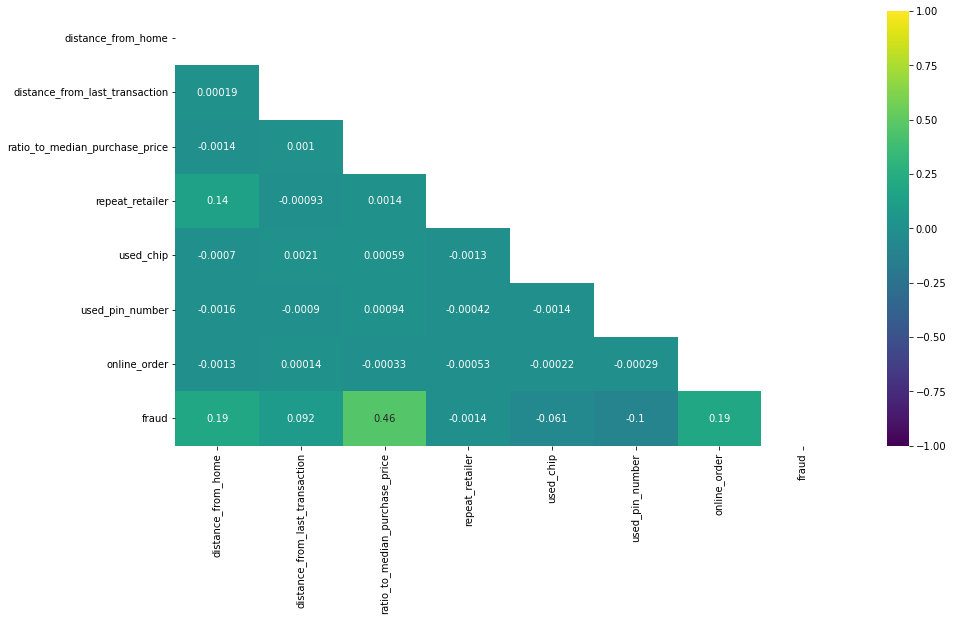

In [12]:
plt.figure(figsize=(15,8))
mask = np.triu(np.ones_like(correlacion, dtype=bool))
sns.heatmap(correlacion, cmap="viridis", annot = True, mask=mask, vmin = -1, vmax=1);

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
distance_from_home,1000000.0,26.628792,65.390784,0.004874,3.878008,9.967760,25.743985,10632.723672
distance_from_last_transaction,1000000.0,5.036519,25.843093,0.000118,0.296671,0.998650,3.355748,11851.104565
ratio_to_median_purchase_price,1000000.0,1.824182,2.799589,0.004399,0.475673,0.997717,2.096370,267.802942
repeat_retailer,1000000.0,0.881536,0.323157,0.000000,1.000000,1.000000,1.000000,1.000000
used_chip,1000000.0,0.350399,0.477095,0.000000,0.000000,0.000000,1.000000,1.000000
used_pin_number,1000000.0,0.100608,0.300809,0.000000,0.000000,0.000000,0.000000,1.000000
online_order,1000000.0,0.650552,0.476796,0.000000,0.000000,1.000000,1.000000,1.000000
fraud,1000000.0,0.087403,0.282425,0.000000,0.000000,0.000000,0.000000,1.000000


In [14]:
df["fraud"].value_counts()

0.0    912597
1.0     87403
Name: fraud, dtype: int64

In [15]:
df["online_order"].value_counts()

1.0    650552
0.0    349448
Name: online_order, dtype: int64

In [17]:
df["used_pin_number"].value_counts()

0.0    899392
1.0    100608
Name: used_pin_number, dtype: int64

In [18]:
df["used_chip"].value_counts()

0.0    649601
1.0    350399
Name: used_chip, dtype: int64

In [19]:
df["repeat_retailer"].value_counts()

1.0    881536
0.0    118464
Name: repeat_retailer, dtype: int64

In [27]:
columnas_cat = ["used_chip", "repeat_retailer", "used_pin_number", "online_order", "used_pin_number", "fraud"]
for columna in columnas_cat:
    df[columna] = df[columna].astype("category")

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype   
---  ------                          --------------    -----   
 0   distance_from_home              1000000 non-null  float64 
 1   distance_from_last_transaction  1000000 non-null  float64 
 2   ratio_to_median_purchase_price  1000000 non-null  float64 
 3   repeat_retailer                 1000000 non-null  category
 4   used_chip                       1000000 non-null  category
 5   used_pin_number                 1000000 non-null  category
 6   online_order                    1000000 non-null  category
 7   fraud                           1000000 non-null  category
dtypes: category(5), float64(3)
memory usage: 27.7 MB


In [29]:
df["distance_from_home"].value_counts()

57.877857     1
17.696734     1
47.933214     1
48.300681     1
25.414372     1
             ..
145.704144    1
4.501861      1
17.443799     1
3.583736      1
58.108125     1
Name: distance_from_home, Length: 1000000, dtype: int64

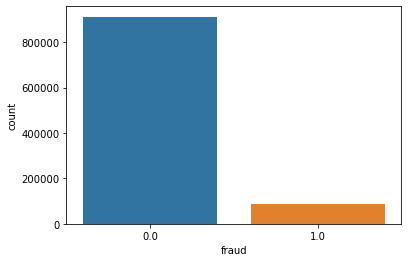

In [30]:
#Gráfica para ver la variable respuesta
sns.countplot(data= df, x = "fraud");

IndexError: index 4 is out of bounds for axis 0 with size 4

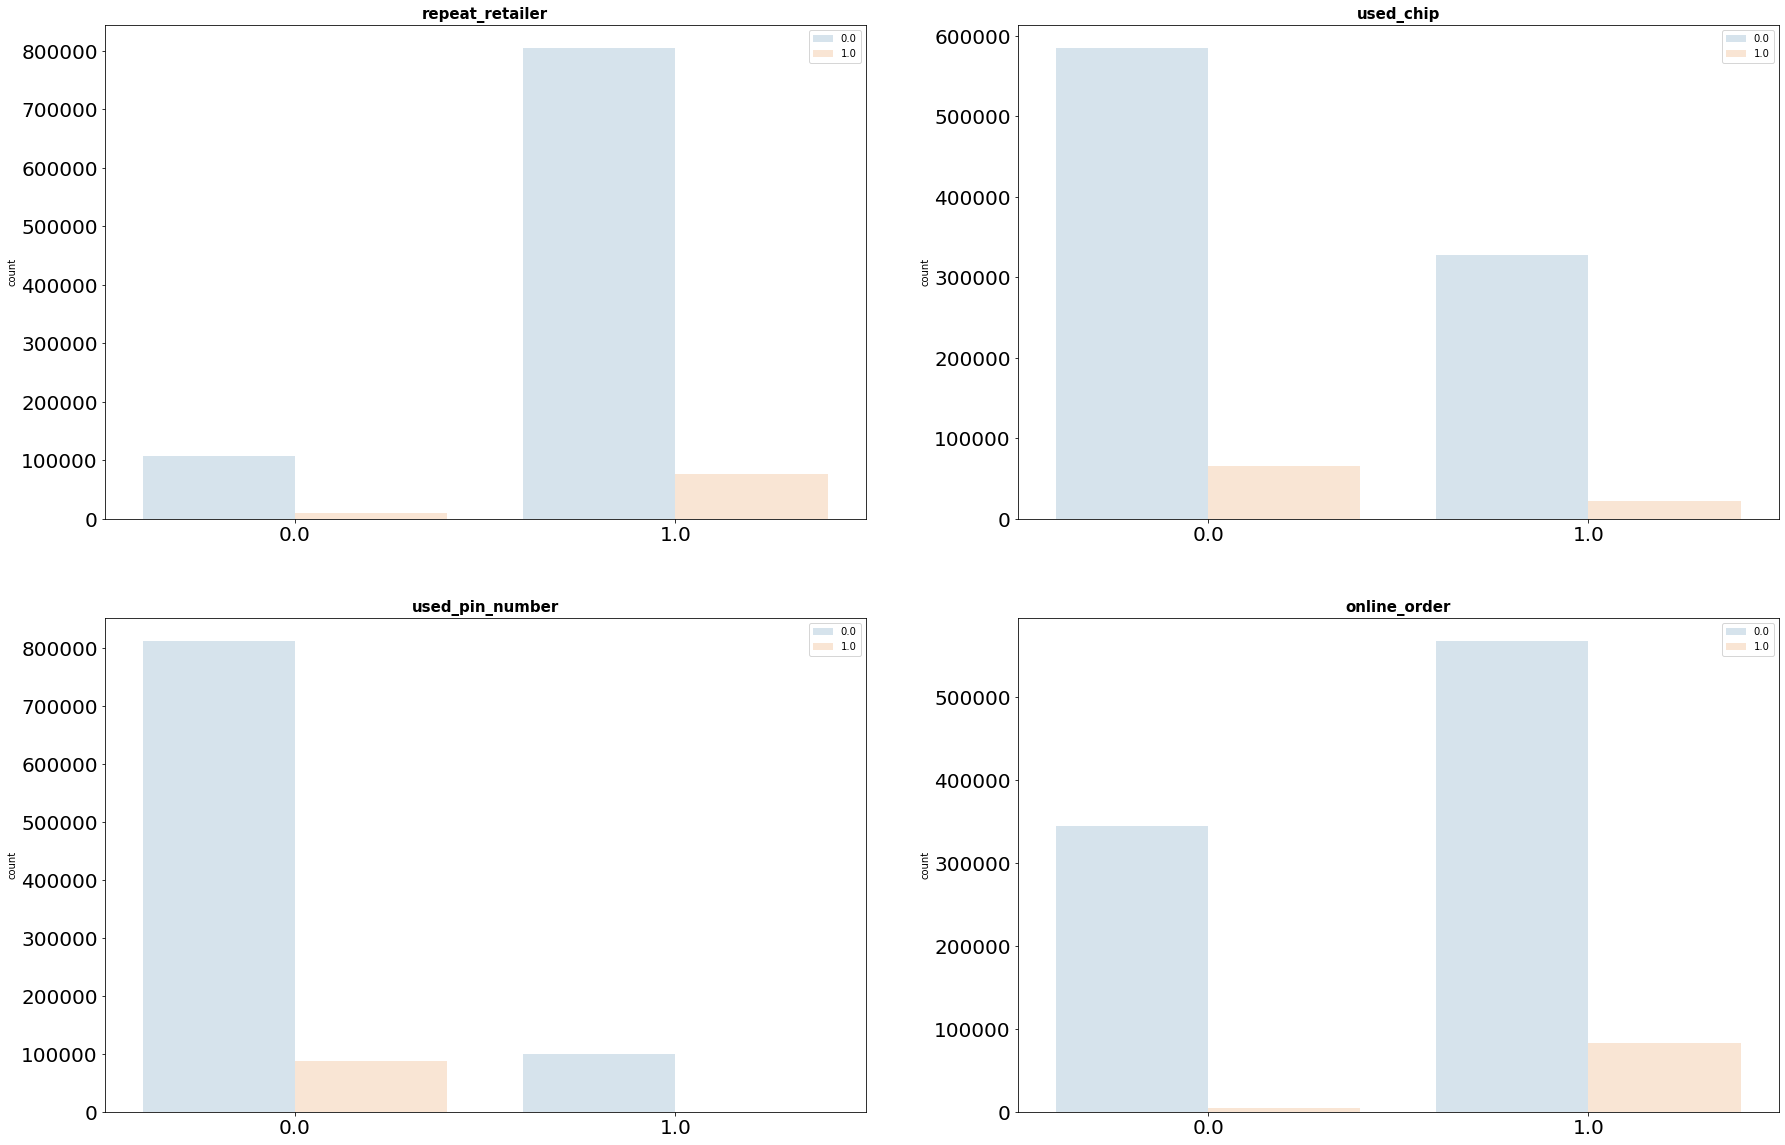

In [32]:

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 20))

axes = axes.flat
columnas_cat = df.select_dtypes(include = "category").columns

for i, colum in enumerate(columnas_cat): 
    sns.countplot(
        data = df,
        x = colum,
        hue = "fraud",
        alpha = 0.2, 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].legend(loc= "upper right")

fig.tight_layout();

De estos gráficos deducimos que los fraudes suelen ser en pagos recurrentes en compra online y sin usar el número pin.

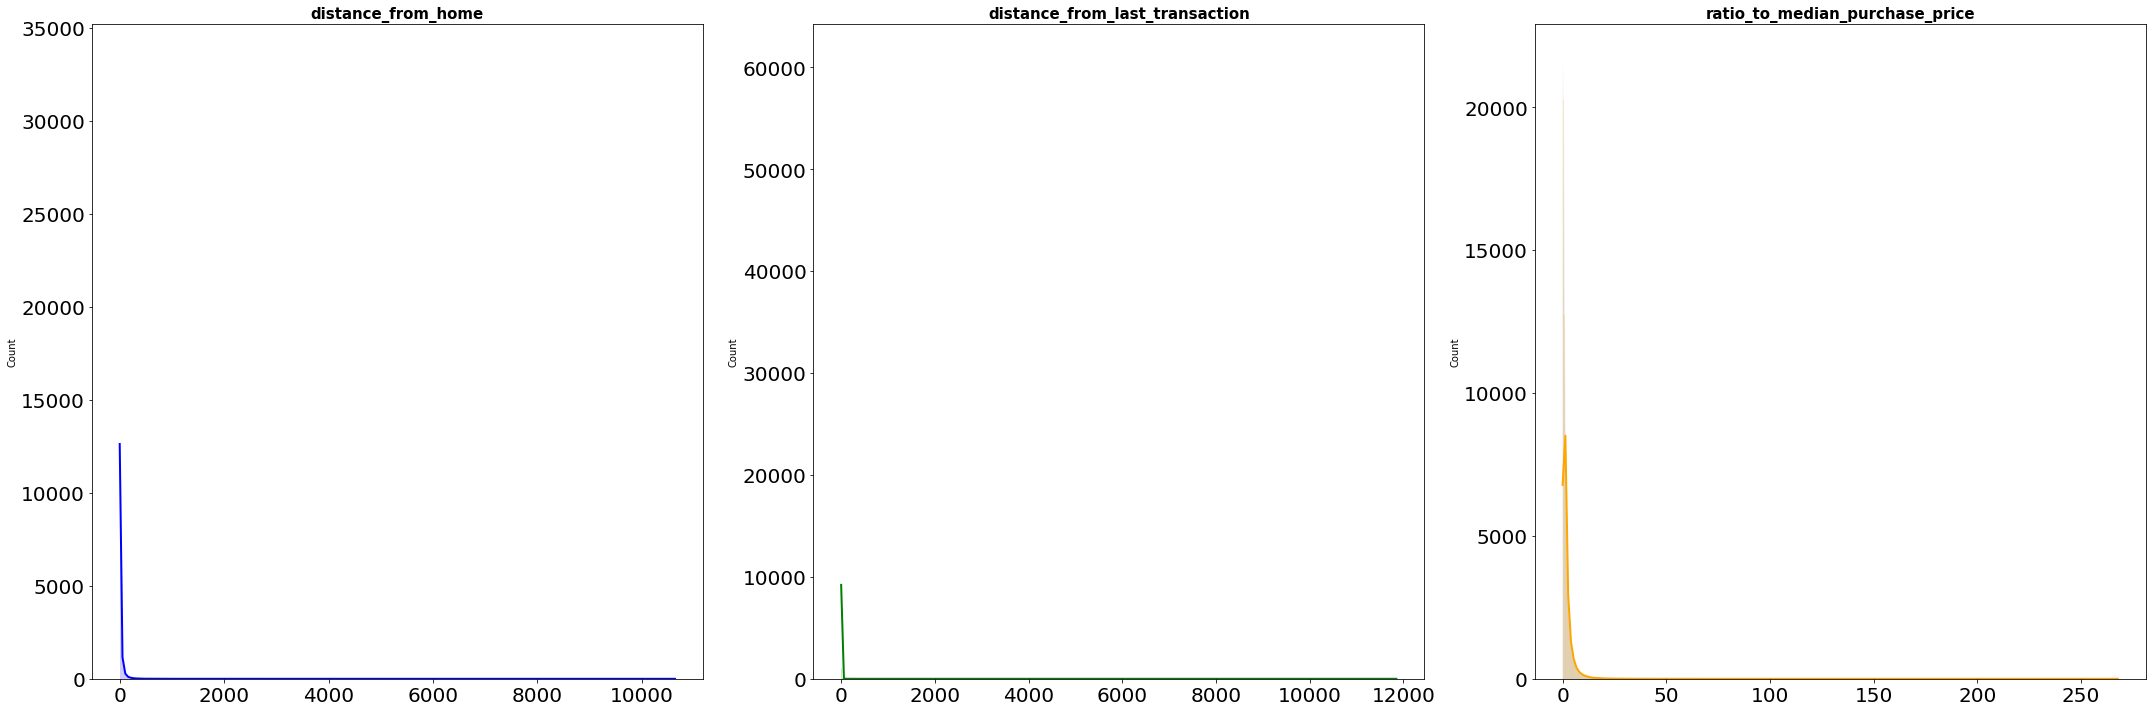

In [33]:

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))

lista_colores = ["blue", "green", "orange"]

axes = axes.flat

columnas_numeric = df.select_dtypes(include = np.number).columns

for i, colum in enumerate(columnas_numeric): 
    sns.histplot(
        data = df,
        x = colum,
        kde = True, 
        color = lista_colores[i], 
        line_kws = {"linewidth": 2}, 
        alpha = 0.2, 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    
fig.tight_layout();

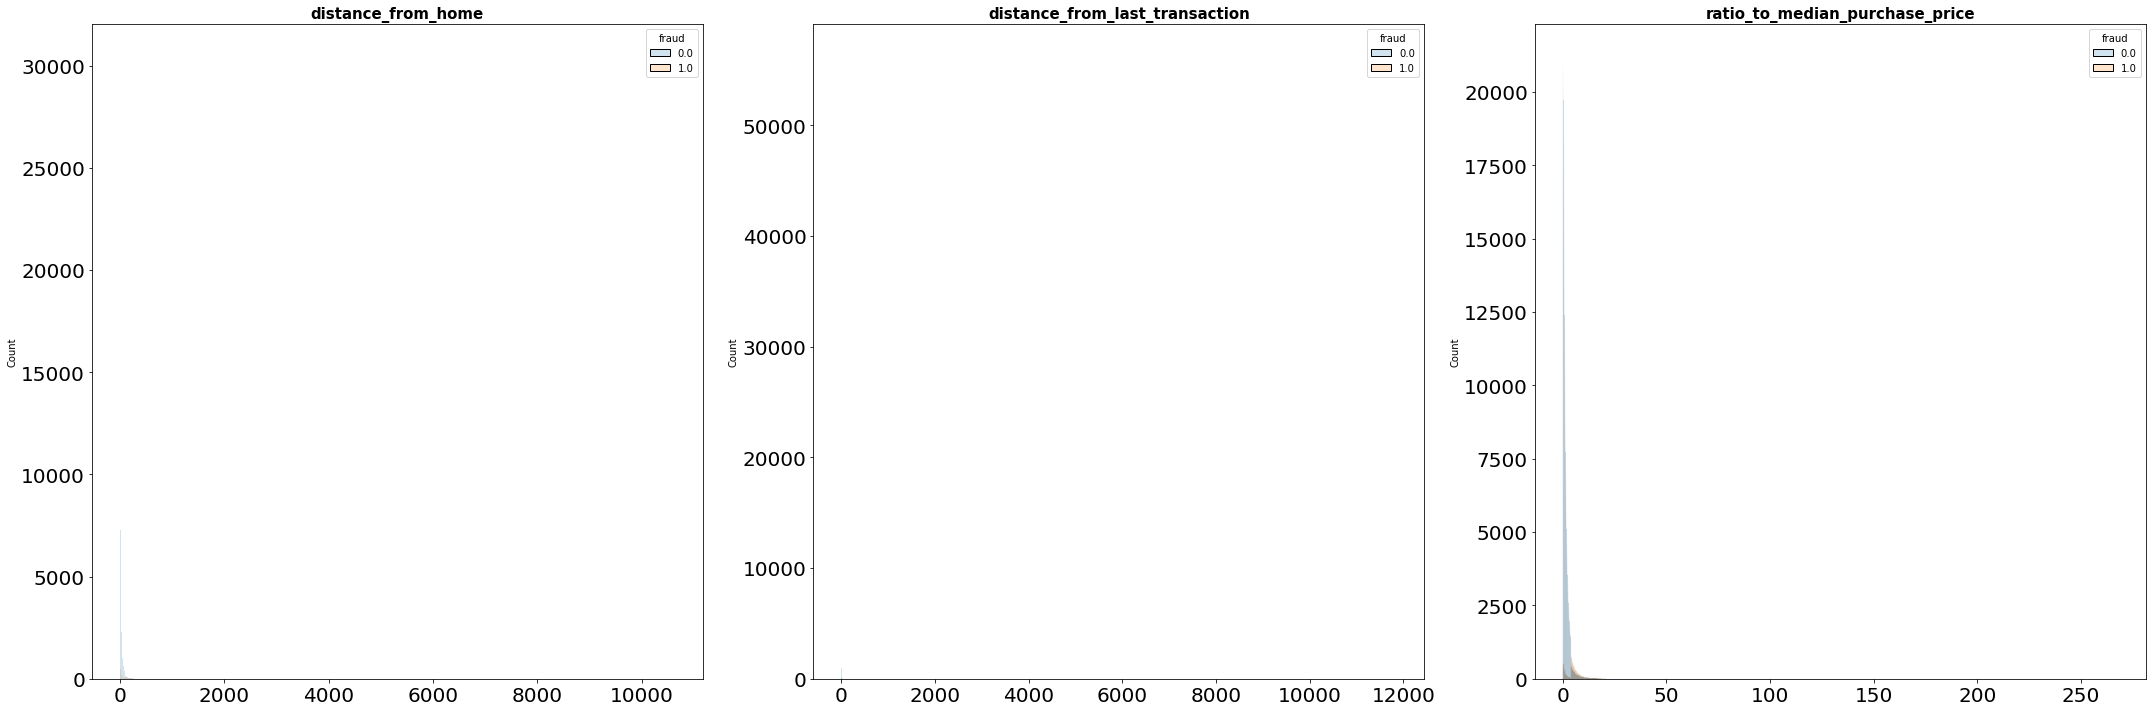

In [35]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))

lista_colores = ["blue", "green", "orange"]

axes = axes.flat

columnas_numeric = df.select_dtypes(include = np.number).columns

for i, colum in enumerate(columnas_numeric): 
    sns.histplot(
        data = df,
        x = colum,
        hue = "fraud",
        color = lista_colores[i], 
        line_kws = {"linewidth": 2}, 
        alpha = 0.2, 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    
fig.tight_layout();

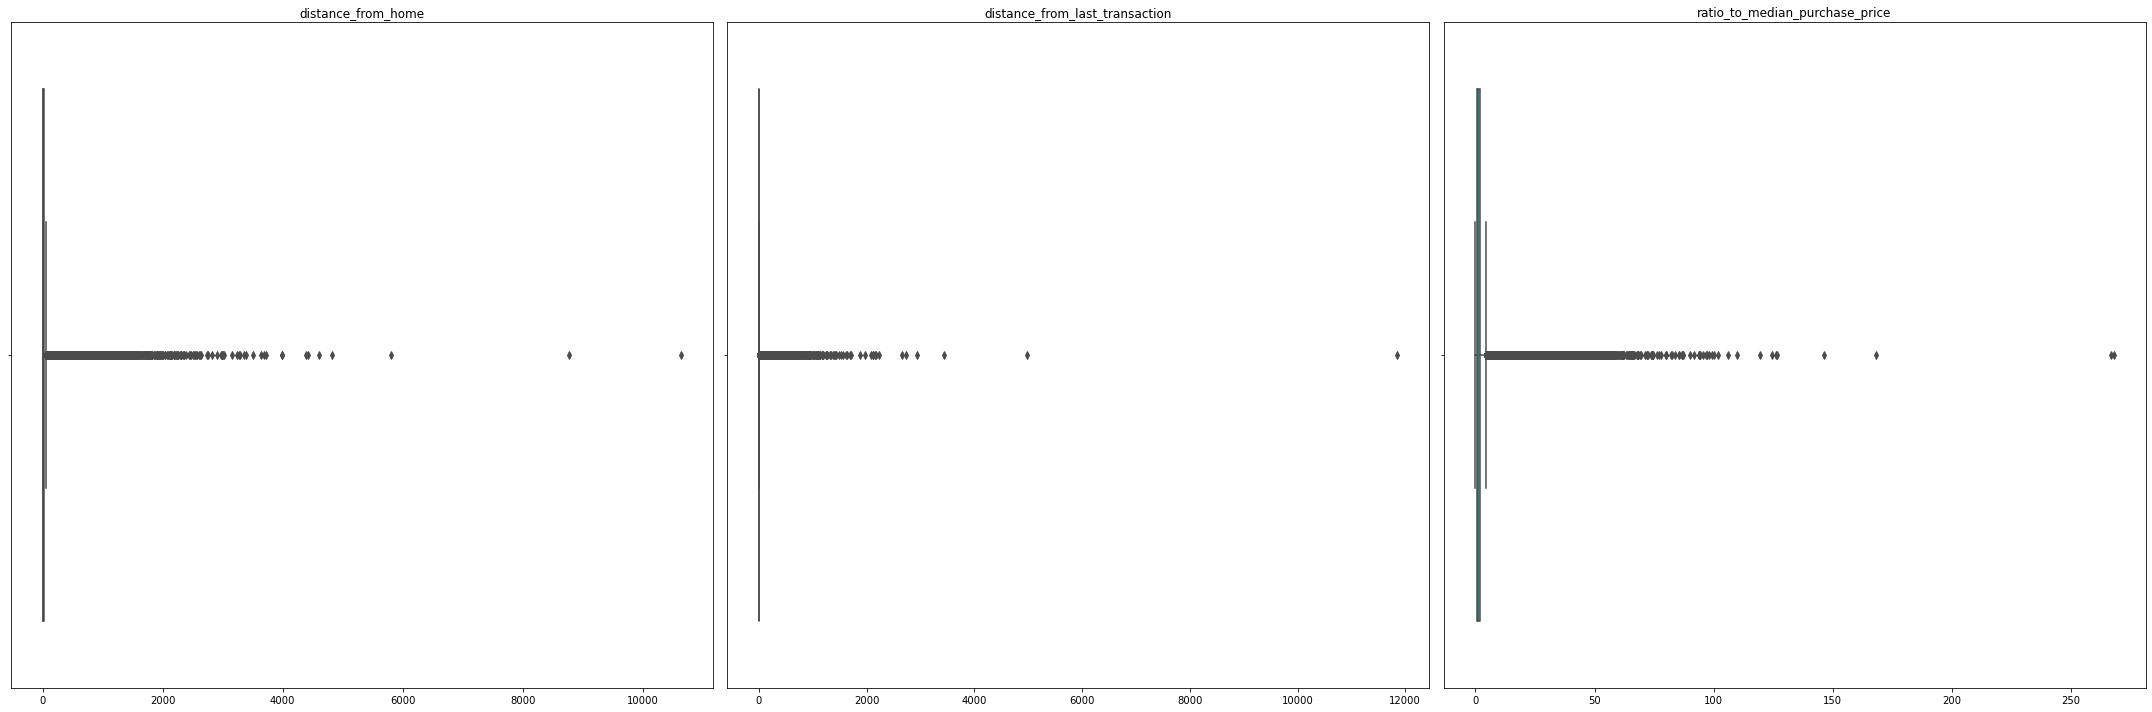

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(30,10))

categorias = df.select_dtypes(include = np.number).columns

axes = axes.flat

for indice, cate in enumerate(categorias):

    sns.boxplot(x = df[cate], data = df, ax=axes[indice], color = "cyan"); # para trazar una línea de densidad

    axes[indice].set_title(cate)
    axes[indice].set_xlabel("")

fig.tight_layout();

In [36]:
df.to_pickle("data/card_limpio.pkl")